# C. GP for Classification and TurboGP cli interface

In this notebook we make use of sci-kit learn alike interface of TurboGP (introduced in notebooks A and B) to apply GP to classification tasks in a easy and prompt way. This notebooks describes every step, from downloading well-known standard classification datasets from the UCI[1] repository, to visualizing and evaluating the performance of obtained models.

Later on, on this same notebook, another classification example on how to use TurboGP from the command line interface (cli) is presented.

1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 


Import basic standard libraries required by TurboGP:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Import TurboGP library, including the python file that defines the type of individual to evolve

In [2]:
from genetic_program import GeneticProgram

from Classifier import *          # GP individual we will use
from GPUtils import binary_tournament

Obtaining and setting up Breast Cancer Wisconsin dataset (WDBC) from the UCI repository. 

WDBC is a very popular binary classification dataset, that usually ranks tops among the all-time most popular used datasets from the UCI repository. 

The following piece of code requires two additional python modules in order to retrieve and configure WDBC, ``pandas`` and ``wget``.

In [3]:
import pandas as pd
import wget

# Retrieve WDBC
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
wget.download(url, 'wdbc.data')

# it is in csv format, so we will use pandas to reconfigure it to a ML-friendly numpy array format
wdbc = pd.read_csv("wdbc.data", header=None)
x = wdbc.drop([0,1], axis=1).to_numpy()
y = np.asarray([1.0 if label == 'M' else 0.0 for label in wdbc[1]])

# The datasset is comprised of 569 samples
print(len(x))

569


Separate some data for testing

In [4]:
# samples
x_training = x[0:500]
y_training = y[0:500]

x_testing = x[500:]
y_testing = y[500:]

Define GP run parameters. In the case of BinaryClassifier, it has one additional optional parameter with respect to SimpleRegressor: the metric used to guide the evolutionary process; if it is not specified, it defaults to 'accuracy'; Here, for purely demo purposes, will set it to 'f1_score', but every classification problem is different. Other metrics, such as cross entropy / log loss are not defined, but shouldn't be too difficult to implement.

In [5]:
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT']  # Primitives
GeneticProgram.set_primitives(lowlevel=lowlevel)

#gp_individual_class = BinaryClassifier            # Type of individual to evolve
ind_params = {'input_vector_size':30, 'metric':'f1_score', 'complexity':7} 

oper = [BinaryClassifier.mutation,                 # Genetic operations to use.
        BinaryClassifier.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

Initialize predictor requesting a BinaryClassifier as GP individual to evolve:

In [6]:
GP = GeneticProgram(individual_class=BinaryClassifier , 
                    ind_params=ind_params, 
                    operations=oper, 
                    operations_prob=oper_prob, 
                    operations_arity=oper_arity, 
                    pop_size=1000, 
                    generations=50,
                    pop_dynamics="Steady_State", 
                    online=False, 
                    minimization=False,
                    n_jobs=4)

Train/Evolve it!

In [7]:
gp_cls = GP.fit(x_training, y_training)

First evaluation time cost:  0:00:09.874561


100%|██████████| 50/50 [04:43<00:00,  5.67s/it, Training Fitness=0.953]

Training fitness of best individual found:  0.9528795811518325


Let's visualize the generated GP model:

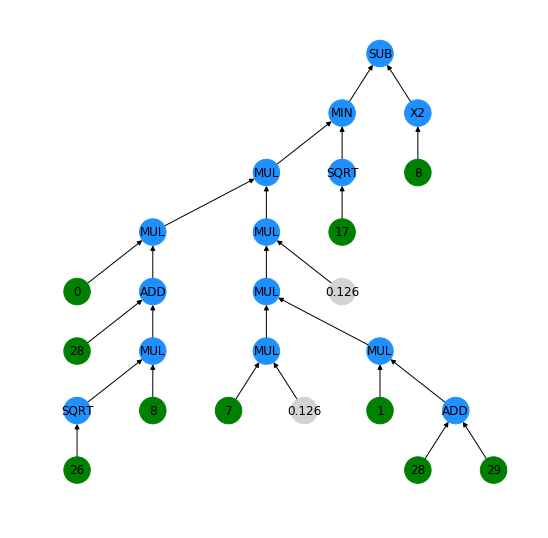

In [8]:
from GPUtils import get_graph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(gp_cls.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Test performance against testing samples

In [9]:
GP.natural_score(x_testing, y_testing)

0.9710144927536232

GP.natural_score uses the default parameters for the score function of the type of individual evolved, which in the case of BinaryClassifier, it means it tests model's performance using ``accuracy`` rather than ``f1_score``, which is the one we used for the evolutionary process. However, we can access the score function of the generated model directly, and request the evaluation using metrics other than accuracy:

In [10]:
gp_cls.score(x_testing, y_testing, metric='f1_score')

0.9411764705882353

In the particular case of medical diagnostics, such as in this example, ``recall`` is probably one of the measures of highest importance when evaluating a models performance:

In [11]:
gp_cls.score(x_testing, y_testing, metric='recall')

0.9411764705882353

A perfect recall of 1.0, would mean that the obtained classifier didn't miss a single positive cancer case as a false negative from the testing set, even if the model generates some false positive.

---

### TurboGP command line interface

TurboGP can be called directly from the console command line, and can generate solutions without having to enter a python interactive shell. The only requirement is to have the GP parameters defined in a JSON file, as well as a the training dataset in a pickled file. In this section we will show how to launch TurboGP using this feature.

This mode can be extremely useful in certain scenarios, such as defining python or shell scripts that automatically run a whole experiment (certain number of tryout runs, under different parameters, and perform statistics over the obtained results), or when deploying distributed (island models) GPs, which will be covered in a follow-up notebook.


First, we will start by downloading a different classification dataset from the UCI repository.

In [12]:
# Retrieve Connectionist Bench, more commonly known as "Sonar" dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
wget.download(url, 'sonar.data')

Sonar is another popular dataset available from the UCI repository. The task consist in distinguish mines from rocks using signal retrieved from a sonar from different angles. It is a small dataset in number of samples (208) but relatively high dimensional (60 features) for GP.

The next step, as in the previous example, consists in setting up the downloaded csv data in a ML friendlier, binary, format (numpy array).

In [13]:
# it is in csv format, so we will use pandas to reconfigure it to a ML-friendly numpy array format
sonar = pd.read_csv("sonar.data", header=None)
# sonar dataset comes with samples ordered in rocks and mines, so we will shuffle it:
sonar = sonar.sample(frac=1)
# generate array of samples
x = sonar.drop([60], axis=1).to_numpy()
# generat vector of labels
y = np.asarray([1.0 if label == 'M' else 0.0 for label in sonar[60]])

# The dataset is comprised of 208 samples and 60 features
print(x.shape)

(208, 60)


Separate some data for testing

In [14]:
# samples
x_training = x[0:190]
y_training = y[0:190]

x_testing = x[190:]
y_testing = y[190:]

Now we can pickle the dataset, so it can be retrieved by TurboGP when executed from the command line. The key here is to store the dataset using the following nomenclature for training, testing, samples and labels, because this is how TurboGP will attempt to read dataset from the pickled file.:

In [15]:
import pickle

connectionist_bench_sonar = {'x_training': x_training,
                             'y_training': y_training,
                             'x_testing': x_testing,
                             'y_testing': y_testing}

pickle.dump(connectionist_bench_sonar, open("sonar.npz", "wb"), protocol=2 )

TurboGP will also need a JSON file specifiying the setup run parameters. We can generate such file from python by defining a dictionary, and then saving it to disk with the aid of the JSON module.

In [16]:
run_params = {
        'dataset': 'sonar.npz',
        'lowlevel': ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT'],
        'ind_module': 'Classifier',
        'ind_name': 'BinaryClassifier',
        'ind_params': {'input_vector_size':60, 'metric':'f1_score', 'complexity':9},
        'oper': ['mutation', 'protected_crossover'],
        'oper_prob': [.5, .5],
        'oper_arity': [1, 2],
        'no_populations': 1,
        'this_population': 0,
        'pop_size': 1000,
        'generations': 100,
        'every_gen': 10, 
        'top_percent': .1,
        'topology': None,
        'pop_dynamics': "Steady_State",
        'online': False,
        'minimization': False,
        'sel_mechanism': 'binary_tournament',
        'n_jobs': 4
        }

import json

with open("sonar_params", "w") as fout:
    fout.write(json.dumps(run_params))

Notice that in the above configuration, there are 5 new parameters that have not been described yet: ``no_populations``, ``this_population``, ``every_gen``, ``top_percent`` and ``topology``. These parameters concern distributed (island) evolutionary models, which will be covered in the next notebook; for the time being, we will just leave them to the setting defined above, which correspond to a standard, single population, algorithm, also called _panmictic_ model within the context of multipopulation evolutionary algorithms (``no_populations=1``).

Now we have everything needed to launch TurboGP from the command line. For didactical purposes, we will launch it here using python functions to launch shell commands.

In [17]:
import os

#os.system("python genetic_program.py sonar_params")
#or
print(os.popen("python genetic_program.py sonar_params").read())

First evaluation time cost:  0:00:04.883877
Training fitness of best individual found:  0.8909090909090909
Pop num:  0  testing data score:  0.8888888888888888



Unfortunately, Python makes it hard to get a live output from the commands launched, so we cannot get to see the progress bar, but using the second command above we can at least get the final output displayed here in the notebook. The output informs that the training concluded achieving a training fitness of 0.9074074074074074 , and scoring a performance of 0.8333333333333334 in the test set.

When launching TurboGP in this mode, the final model obtained is stored to disk in a file named ``Population-#f`` where # is the number of the population as configured in the setup parameter ``this_population`` (0 in this case).

So we can retrieve the generated model as follows:

In [18]:
model = pickle.load(open("Population-0f", "rb"))['Content'][0]

In [19]:
model

Now we can handle the obtained model as usual, and perform tasks such as evaluate it, display it, etc.

In [20]:
model.score(x_testing, y_testing, metric='accuracy')

0.8888888888888888

In [21]:
model.score(x_testing, y_testing, metric='f1_score')

0.9090909090909091

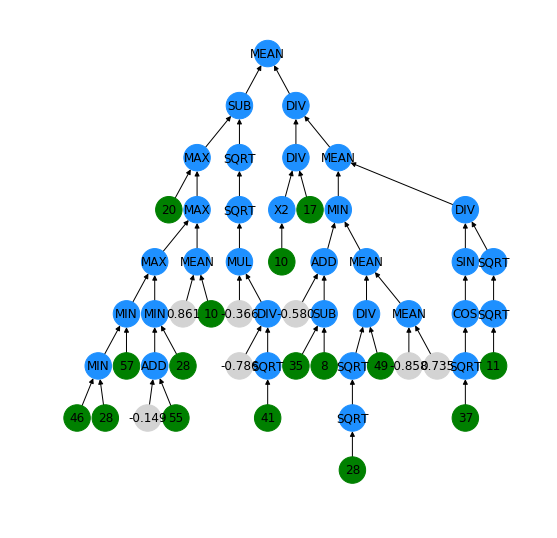

In [23]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(model.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

---

### TurboGP CLI under Online learning mode

In the example above we used TurboGP CLI mode for a rather small dataset, so we stick with conventional evolution/training each generation using the whole training dataset. However, as we have seen in previous examples, TurboGP also provides mini-batch based learning, i.e. online learning, which offers a couple of advantages over the more traditional offline, or batched, learning.

Using TurboGP CLI under online learning mode is pretty much the same as the offline mode, the only major difference is when generating the dataset npz pickle files, as this should contain the mini-batches already defined.

For an example, let's use another classic UCI dataset: banknote authentication dataset. This dataset is geared towards training algorithms to learn to distingish authentic bills from fake ones. This dataset is comprised of 1372 examples, which is considerably larger than the Sonar dataset, thus making ideal for an online learning approach.

First, let's start by retrieving the dataset:

In [24]:
# Retrieve  banknote authentication Data Set 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
wget.download(url, 'banknote.data')

# it is in csv format, so we will use pandas to reconfigure it to a ML-friendly numpy array format
banknote = pd.read_csv("banknote.data", header=None)
# sonar dataset comes with samples ordered in rocks and mines, so we will shuffle it:
banknote = banknote.sample(frac=1)
# generate array of samples
x = banknote.drop([4], axis=1).to_numpy()
# generat vector of labels
y = np.asarray(banknote[4])

# The dataset is comprised of 208 samples and 60 features
print(x.shape)

(1372, 4)


Now we will separate some data for testing, and reshape the training dataset into mini batches of any size we desire.

In [25]:
x_training = x[0:1200]
y_training = y[0:1200]

batchesX = x_training.reshape(12, 100, 4)
batchesY = y_training.reshape(12, 100)

x_testing = x[1200:]
y_testing = y[1200:]

Now we store the dataset the following way:

In [26]:
banknote_authentication_ds = {'batchesX': batchesX,
                             'batchesY': batchesY,
                             'x_testing': x_testing,
                             'y_testing': y_testing}

pickle.dump(banknote_authentication_ds, open("banknote.npz", "wb"), protocol=2 )

Notice how, the difference between datasets meant for online and batched learning, consists in the way training datasets are stored: for online learning the mini-batches must be defined and saved with such nomenclature.

We also need to specify in the run parameters that we wish online mode:

In [27]:
run_params = {
        'dataset': 'banknote.npz',
        'lowlevel': ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT'],
        'ind_module': 'Classifier',
        'ind_name': 'BinaryClassifier',
        'ind_params': {'input_vector_size':4, 'metric':'accuracy', 'complexity':9},
        'oper': ['mutation', 'protected_crossover'],
        'oper_prob': [.5, .5],
        'oper_arity': [1, 2],
        'no_populations': 1,
        'this_population': 0,
        'pop_size': 1000,
        'epochs': 10,
        'every_gen': 10, 
        'top_percent': .1,
        'topology': None,
        'pop_dynamics': "Steady_State",
        'online': True,
        'minimization': False,
        'sel_mechanism': 'binary_tournament',
        'n_jobs': 4
        }

with open("banknote_params", "w") as fout:
    fout.write(json.dumps(run_params))

Notice also how rather than declaring the number of generations to elapse, as in the previous example above, here we define the number of _epochs_ to elapse; the number of generations is calculated automatically ($generations = numberofminibatches * epochs$).

Let's launch it

In [28]:
print(os.popen("python genetic_program.py banknote_params").read())

First evaluation time cost:  0:00:02.416192
Training fitness of best individual found:  1.0
Pop num:  0  testing data score:  1.0



In [29]:
model = pickle.load(open("Population-0f", "rb"))['Content'][0]

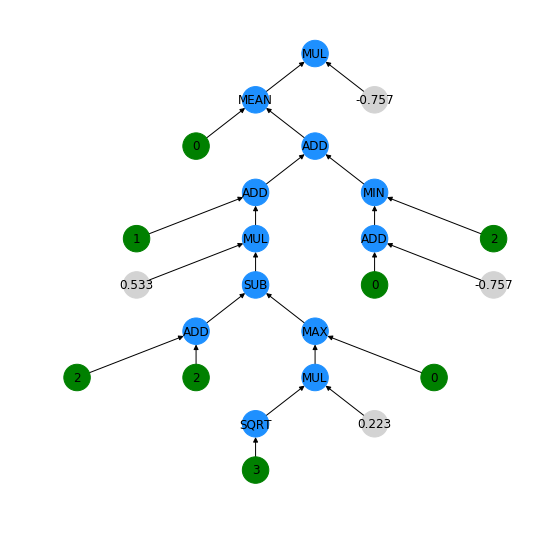

In [30]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(model.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)